In [ ]:
#### IMPORTS ####

import pandas as pd
from sklearn.model_selection import StratifiedKFold
from datasets import load_dataset
import utils
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, average_precision_score
import xgboost as xgb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

/Users/matt/Desktop/CS690U/project/.conda/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#### LOAD DATASET ####

ec_ds = load_dataset("tattabio/ec_classification")
train_val_ds = ec_ds["train"]
test_ds = ec_ds["test"]

train_val_df = train_val_ds.to_pandas()
test_df = test_ds.to_pandas()

print(f"Train: {len(train_val_df)} samples, Test: {len(test_df)} samples")

Train: 512 samples, Test: 128 samples


In [3]:
# CONSTANTS
AMINO_ACIDS = "ACDEFGHIKLMNPQRSTVWY"
amac_to_idx = {amac: i for i, amac in enumerate(AMINO_ACIDS)}
max_train_sequence_length = max(train_val_df['Sequence'].apply(len))

In [4]:
#### PREPROCESS DATASET ####
train_val_df["Sequence"] = train_val_df["Sequence"].apply(lambda x: utils.remove_unknown_chars(x, amac_to_idx))
test_df["Sequence"] = test_df["Sequence"].apply(lambda x: utils.remove_unknown_chars(x, amac_to_idx))

train_val_df["Label"], test_df["Label"] = utils.label_encode(train_val_df, test_df)


In [44]:
### DEFINE ENCODINGS TO COMPARE ####
kmer_encodings = [("kmer", utils.kmer_encode(train_val_df["Sequence"], k=k, min_freq=0.01), k) for k in [3,4,5,6]]
# onehot_encodings = [("one_hot", "mean", None), ("one_hot", "pad", max_train_sequence_length)]


In [45]:
### PERFORM STRATIFIED K-FOLD SPLIT ####
strat_kfold = StratifiedKFold(n_splits=4, shuffle=True, random_state=21)

In [46]:
# PARAM GRID FOR XGBOOST
param_grid = {
    "max_depth": [3, 4, 5],
    "n_estimators": [50, 75, 100],
    "learning_rate": [0.01, 0.03, 0.1],
    "reg_lambda": [0, 1e-3, 1e-1, 1e-4],
    "reg_alpha": [0, 0.1, 0.3],
    "gamma": [0, 0.1, 0.5],
}

In [ ]:
### PERFORM TRAINING AND GRID SEARCH ####
kmer_results = []

for encoding in kmer_encodings:

    X_train, y_train = utils.extract_features(train_val_df, encoding)
    # DEFINE MODEL
    model = xgb.XGBClassifier(
            objective="multi:softprob",
            eval_metric="mlogloss",
            random_state=21,
            )

    # PERFORM GRID SEARCH
    grid_search = GridSearchCV(
            estimator=model,
            param_grid=param_grid,
            scoring="f1_macro",
            cv=strat_kfold,
            verbose=1,
            n_jobs=4,
            return_train_score=True,
        )
    grid_search.fit(X_train, y_train)

    kmer_results.append({
        "encoding_type": encoding[0] + "_" + str(encoding[2]),
        "encoding": encoding,
        "best_params": grid_search.best_params_,
        "cv_results": grid_search.cv_results_,
        "best_estimator": grid_search.best_estimator_,
        "best_score": grid_search.best_score_,
    })



Fitting 4 folds for each of 324 candidates, totalling 1296 fits
Fitting 4 folds for each of 324 candidates, totalling 1296 fits
Fitting 4 folds for each of 324 candidates, totalling 1296 fits
Fitting 4 folds for each of 324 candidates, totalling 1296 fits


In [13]:
## SAVE BEST MODELS ###
for result in kmer_results:
    model = result["best_estimator"]
    encoding = result["encoding"]
    encoding_type = result["encoding_type"]
    joblib.dump(model, f"xgboost_{encoding_type}.joblib")
    print(f"Model saved for encoding {encoding_type} with params {result['best_params']}")


Model saved for encoding kmer_3 with params {'gamma': 0.1, 'learning_rate': 0.03, 'max_depth': 3, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 0.1}
Model saved for encoding kmer_4 with params {'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'reg_alpha': 0, 'reg_lambda': 0}
Model saved for encoding kmer_5 with params {'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'reg_alpha': 0, 'reg_lambda': 0}
Model saved for encoding kmer_6 with params {'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'reg_alpha': 0, 'reg_lambda': 0}


In [ ]:
# DISPLAY VALIDATION RESULTS
train_val_results = kmer_results
train_val_results_df = pd.DataFrame(train_val_results).sort_values("best_score", ascending=False)
print(train_val_results_df[["encoding_type", "best_score"]])
        

  encoding_type  best_score
0        kmer_3    0.107845
1        kmer_4    0.100975
2        kmer_5    0.013656
3        kmer_6    0.006963


In [ ]:
#### EVALUATE BEST MODEL ON TEST SET ####
test_results = []

for res in train_val_results:
    encoding_type = res["encoding_type"]
    encoding = res["encoding"]
    best_params = res["best_params"]
    

    X_train, y_train = utils.extract_features(train_val_df, encoding)
    best_model = xgb.XGBClassifier(
            objective="multi:softprob",
            eval_metric="mlogloss",
            random_state=31,
            **best_params,
            )

    best_model.fit(X_train, y_train)
    
    X_test, y_test = utils.extract_features(test_df, encoding)
    y_pred = best_model.predict(X_test)
    y_pred_probabilities = best_model.predict_proba(X_test)

    f1 = f1_score(y_test, y_pred, average="macro")
    accuracy = accuracy_score(y_test, y_pred)
    average_precision = average_precision_score(y_test, y_pred_probabilities, average="macro")

    test_results.append({
        "encoding_type": encoding_type,
        "f1": f1,
        "accuracy": accuracy,
        "average_precision": average_precision,
        "num_params": best_params["n_estimators"] * (2 ** best_params["max_depth"]),
    })
final_results_df = pd.DataFrame(test_results)


print(final_results_df[["encoding_type", "f1", "accuracy", "average_precision"]]) 

  encoding_type        f1  accuracy  average_precision
0        kmer_3  0.134115  0.171875           0.237294
1        kmer_4  0.090365  0.117188           0.172875
2        kmer_5  0.019676  0.031250           0.039791
3        kmer_6  0.007940  0.015625           0.023686


In [78]:
## LOAD DGEBS RESULTS FOR COMPARISON ##
dgeb_results = pd.read_csv("dgeb_model_results.csv")

xgboost_results_df = pd.DataFrame({
    "Model_Type": ["xgboost"] * len(final_results_df),
    "Model_Family": ["xgboost"] * len(final_results_df),
    "Model": final_results_df["encoding_type"],
    "Num_Params": final_results_df["num_params"],
    "Score": final_results_df["f1"],
})

model_results_df = pd.concat([dgeb_results, xgboost_results_df], ignore_index=True).sort_values("Num_Params").reset_index(drop=True)
model_results_df.to_csv("model_results.csv", index=False)
model_results_df

,Model_Type,Model_Family,Model,Num_Params,Score
0,xgboost,xgboost,kmer_6,400,0.007940
1,xgboost,xgboost,kmer_4,400,0.090365
2,xgboost,xgboost,kmer_5,400,0.019676
3,xgboost,xgboost,kmer_3,800,0.134115
4,AA Models,ESM2,esm2_t6_8M,8000000,0.437000
5,NA Models,Nucleotide_Transformer,NT_v2-50m_Multispecies,55000000,0.070000
6,NA Models,Nucleotide_Transformer,NT_v2-100m_Multispecies,98000000,0.086000
7,AA Models,Progen,progen2-small,150000000,0.437000
8,AA Models,ESM2,esm2_t30_150M,150000000,0.611000
9,NA Models,Nucleotide_Transformer,NT_v2-250m_Multispecies,235000000,0.110000


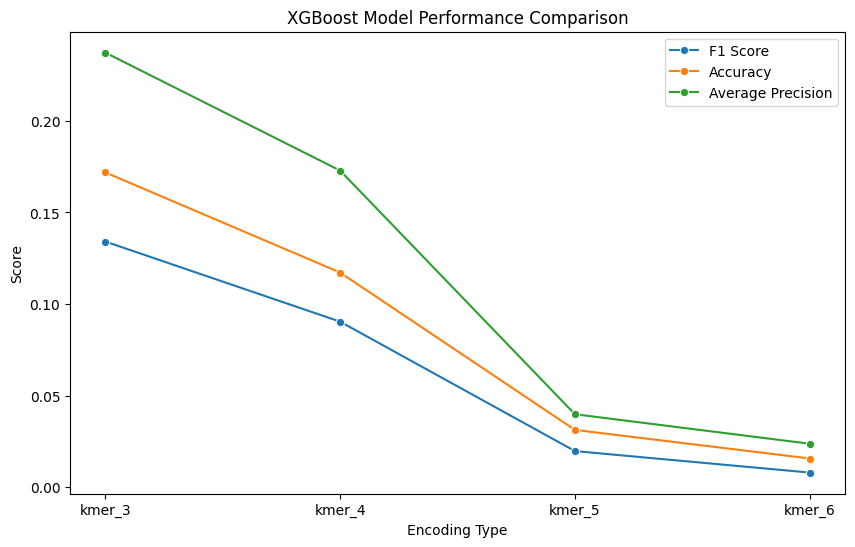

In [ ]:
#### GRAPH RESULTS ####
### PLOT XGBOOST RESULTS ###
plt.figure(figsize=(10, 6))
sns.lineplot(data=final_results_df, x="encoding_type", y="f1", label="F1 Score", marker="o")
sns.lineplot(data=final_results_df, x="encoding_type", y="accuracy", label="Accuracy", marker="o")
sns.lineplot(data=final_results_df, x="encoding_type", y="average_precision", label="Average Precision", marker="o")
plt.title("XGBoost Model Performance Comparison")
plt.xlabel("Encoding Type")
plt.ylabel("Score")
plt.legend()
plt.savefig("xgboost_model_performance.png", dpi=300)




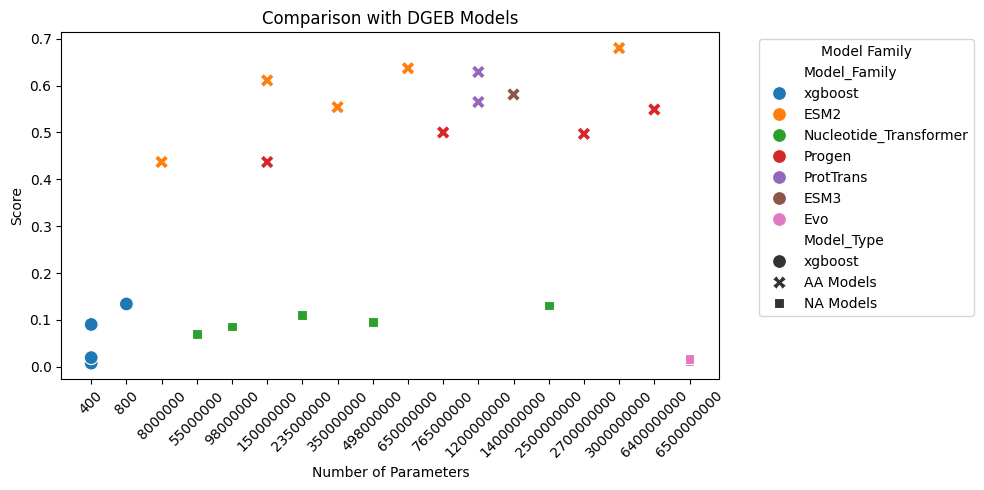

In [76]:
### PLOT COMPARISON WITH DGEBS MODELS ###

plt.figure(figsize=(10, 5))
model_results_df["Num_Params"] = model_results_df["Num_Params"].astype(str)
## Use a scatter plot to show the relationship between number of parameters and score
## Specify the Model next to each point
sns.scatterplot(data=model_results_df, x="Num_Params", y="Score", hue="Model_Family", style="Model_Type", s=100)
plt.title("Comparison with DGEB Models")
plt.xlabel("Number of Parameters")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.legend(title="Model Family", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig("model_comparison.png", dpi=300)

